In [1]:
%load_ext autoreload
%autoreload 2

# Sentinel 1 Flood Finder 

Sometimes, we just want to create a water mask from Sentinel-1 imagery. For that, we don't need to use the full capabilities of the `flood_finder` package. It suffices to use the `WaterFinder` class, which can easily discover Sentinel-1 imagery and derive the water masks from it. This notebook shows how to use it.


## Define an AOI

To start, let's define an Area of Interest (AOI). For that, we can make use of the `geojson.io` interactive map that outputs the `GeoJson` representation of a polygon. In the following example, I've created a Polygon (box) around Porto Alegre city in Rio Grande do Sul state (Brazil). This AOI is geojson converted to a shapely geometry using `shape` function.

In [2]:
from shapely.geometry import shape

poa = {
    "coordinates": [
        [
        [
            -51.50218142686984,
            -29.790441486131606
        ],
        [
            -51.50218142686984,
            -30.18660122418511
        ],
        [
            -50.91175166443446,
            -30.18660122418511
        ],
        [
            -50.91175166443446,
            -29.790441486131606
        ],
        [
            -51.50218142686984,
            -29.790441486131606
        ]
        ]
    ],
    "type": "Polygon"
}


aoi = shape(poa)

## The `WaterFinder` class

The `WaterFinder` class is responsible for creating water masks from Sentinel 1 imagery data pulled automatically the <b>MS Planetary Computer</b>. The date range was defined to capture the grate flood that occurred in May/2024 and at least one image before the flood (one can notice that during 2022 and 2023 just a few images were aqcquired by S1 in the region).

<b>Note:</b> Since the shutdown of the Planetary Computer HUB, from 06/05/2024, the subscription key is no more needed to download S1-RTC datasets. 

In [19]:
from flood_finder import WaterFinder, S1Imagery

s1finder = WaterFinder(
    output_path='../tmp/',
    aoi=aoi,
    time_range='2021-12/2024-06',
    group_items=False,
    lee_size=7,
    print_log=True,
)

s1finder

2024-06-04 20:20:56 | tmp.WaterFinder:INFO -> Starting WaterFinder instance for tmp


2024-06-04 20:20:57 | tmp.WaterFinder:INFO -> Retrieving dates list for the AOI


WaterFinder for place tmp
Available dates: 10
Water detected dates: 0

In [6]:
# Once created the WaterFinder class, we can access the s1imagery attribute to check the images found.
s1finder.s1imagery.dates

array(['2021-12-06', '2021-12-11', '2021-12-18', '2023-09-09',
       '2023-09-14', '2023-09-26', '2023-11-25', '2024-05-11',
       '2024-05-30', '2024-06-01'], dtype=object)

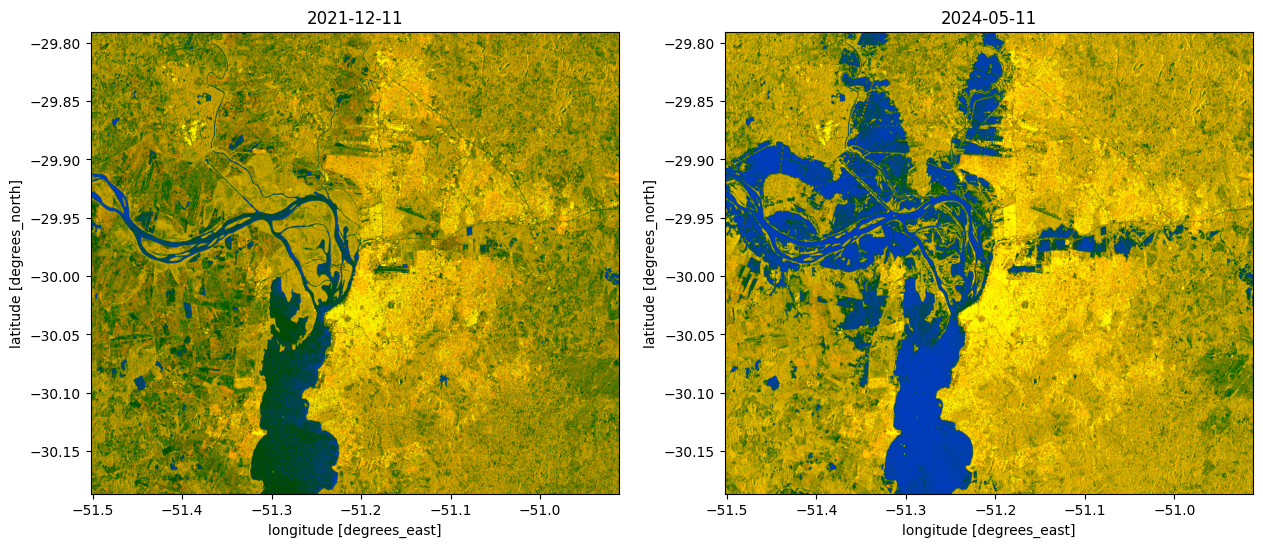

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
dates = ['2021-12-11', '2024-05-11']

for date, ax in zip(dates, axs):
    s1finder.s1imagery.plot_date(date, ax=ax)


## Water Detection

Now, let's move to the water detection phase. 

In [9]:
WaterFinder.GFM_URL

'https://geoserver.gfm.eodc.eu/geoserver/gfm/wms'

In [10]:
mask1 = s1finder.find_water_in_date('2024-05-11', model_path='../model/RF_Model_v2.joblib', use_gfm=True)

2024-06-04 20:12:04 | tmp.WaterFinder:INFO -> Seeking for GFM flood in date: 2024-05-11


In [17]:
img = s1finder.s1imagery['2024-05-11']

In [20]:
rgb = S1Imagery.false_color_xr(img.sel(band='vv'), img.sel(band='vh'))

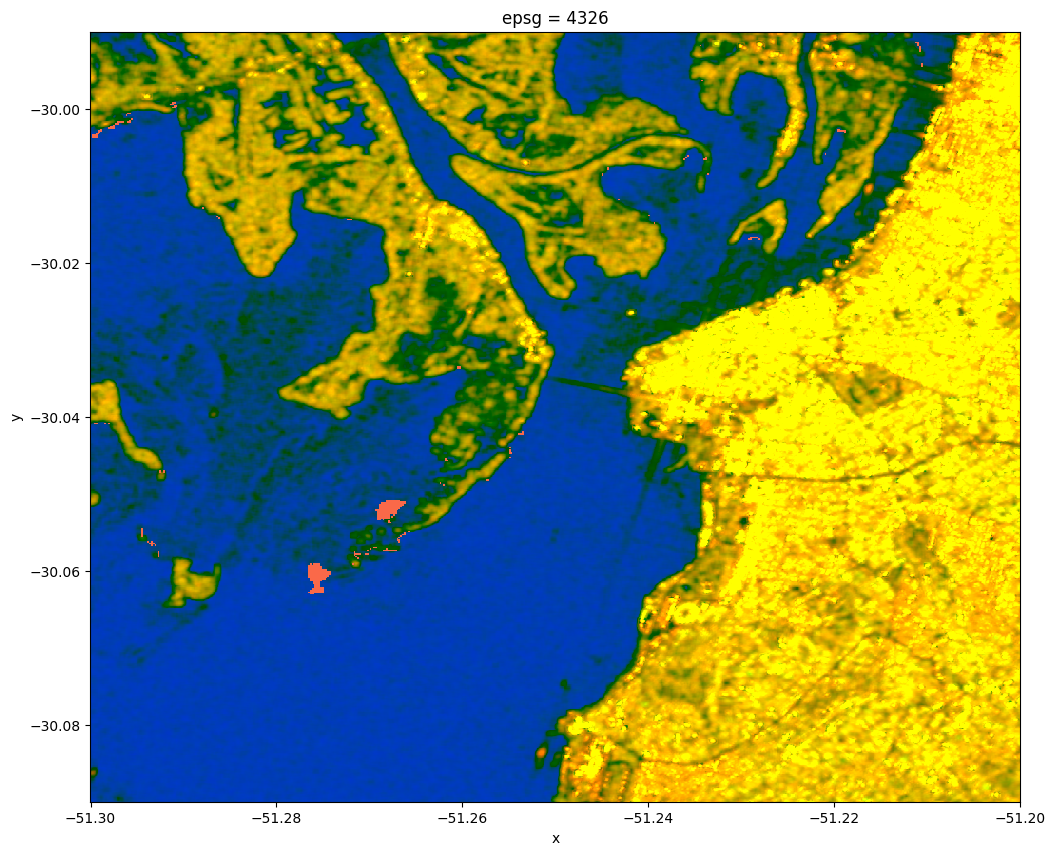

In [42]:
window = dict(x=slice(-51.3, -51.2), y=slice(-29.99, -30.09))
# window = dict(x=slice(-55.2, -41.1), y=slice(-28.95, -32.05))


fig, ax = plt.subplots(figsize=(12, 10))
rgb.sel(**window).plot.imshow(ax=ax, rgb='color_band')
mask1.where(mask1==1).sel(**window).plot.imshow(ax=ax, cmap='Reds', add_colorbar=False)

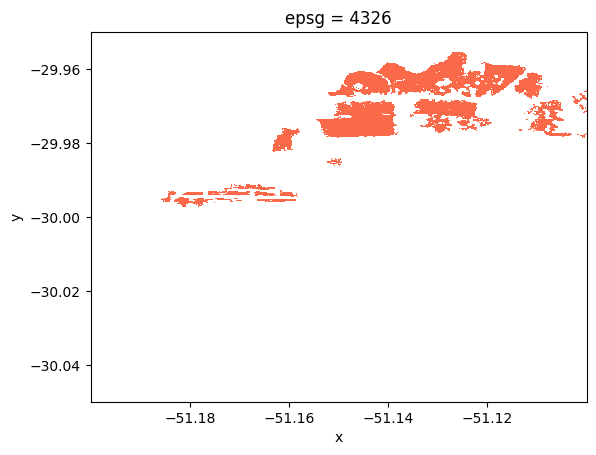

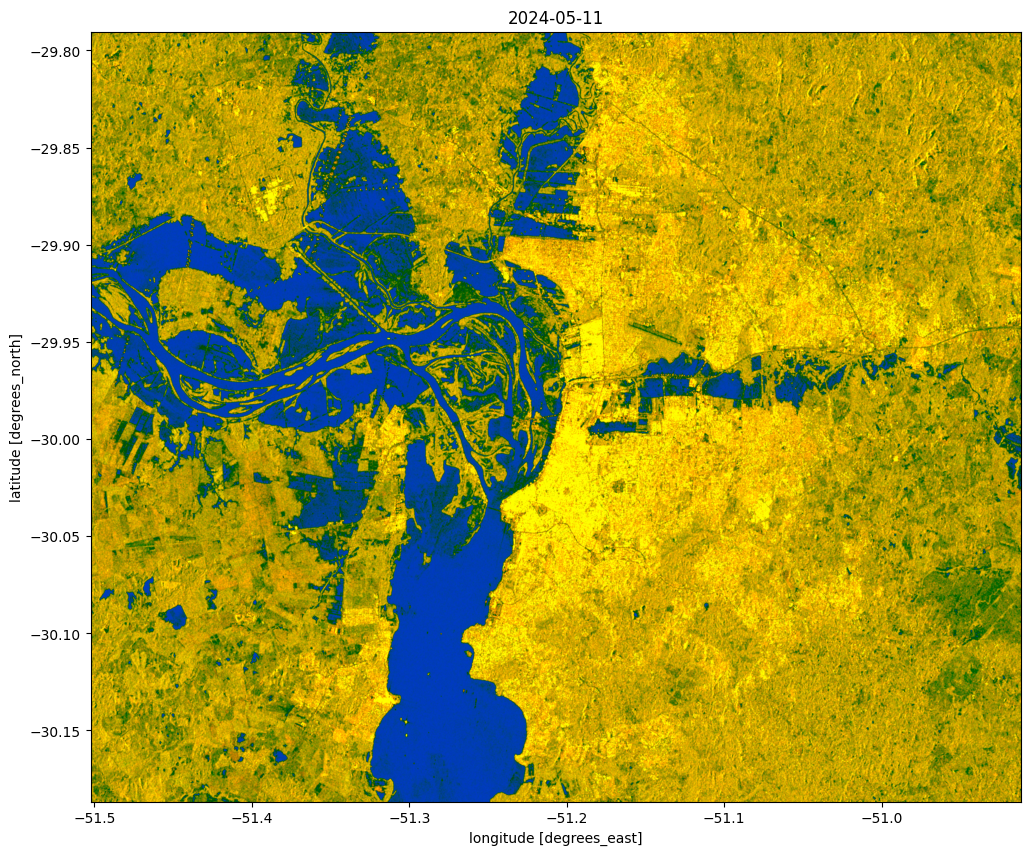

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
s1finder.s1imagery.plot_date('2024-05-11', ax=ax)

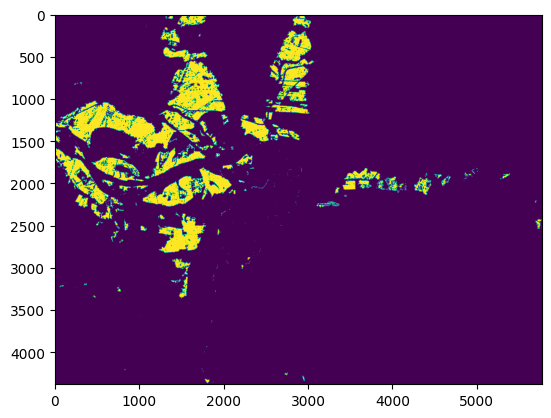

In [13]:
import matplotlib.pyplot as plt
plt.imshow(mask1)

In [14]:
mask2 = s1finder.find_water_in_date('2024-05-11', model_path='../model/RF_Model_v2.joblib', use_gfm=False)

2024-06-01 13:58:47 | tmp.WaterFinder:INFO -> Seeking for water in date: 2024-05-11


In [9]:
mask1

<xarray.DataArray 'stackstac-fbb5312b53ea8512a862e9a0e60bb808' (y: 4380, x: 5772)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * x        (x) float64 -51.5 -51.5 -51.5 -51.5 ... -50.91 -50.91 -50.91 -50.91
  * y        (y) float64 -29.79 -29.79 -29.79 -29.79 ... -30.19 -30.19 -30.19
    epsg     int64 4326
Attributes:
    _FillValue:  0

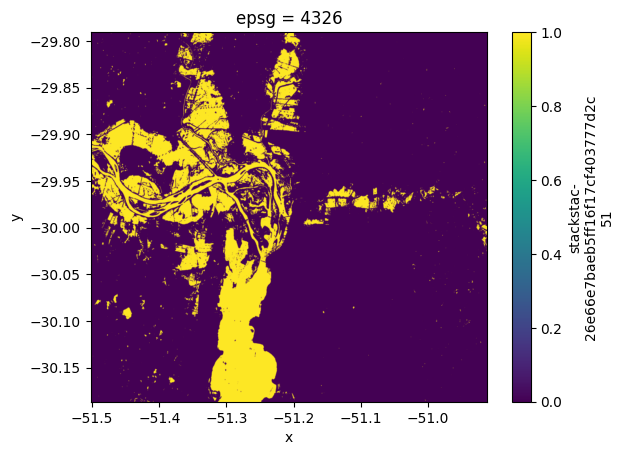

In [15]:
mask2.plot.imshow(interpolation_stage='rgba', interpolation='bilinear')

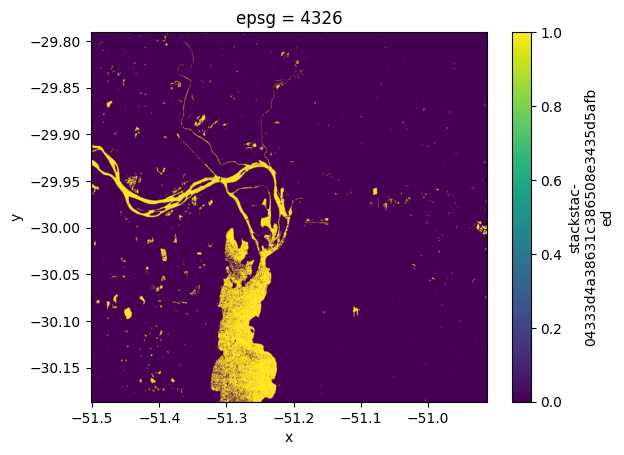

In [20]:
mask1.plot.imshow(interpolation_stage='rgba', interpolation='bilinear')